# Modeling

- Confusion Matrix
- Robustness
- Tree Interpretation

In [140]:
# First we import all neccessary libraries and give some of them an alias for easy access
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import SVMSMOTE
from sklearn.base import clone
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

## Gini SV

In [141]:
# Read in the Data
df = pd.read_csv('../../Data/Transformed/Julius/inventory_management_transformed.csv', index_col=0)
df
# in order to understand the numbers go into label_encodings.txt

,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,Weather Condition,Promotion,Competitor Pricing,Demand,PKeyID,Weekday,Price_Diff
Category,,,,,,,,,,,,,
1,1,195,102,252,72.72,5,1,0,85.73,115,0,2,-13.01
0,1,117,117,249,80.16,15,1,1,92.02,229,1,2,-11.86
0,1,247,114,612,62.94,10,1,1,60.08,157,2,2,2.86
1,1,139,45,102,87.63,10,1,0,85.19,52,3,2,2.44
3,1,152,65,271,54.41,0,1,0,51.63,59,4,2,2.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,1,129,129,128,62.83,10,0,0,74.57,143,17,5,-11.74
2,1,104,54,50,98.97,10,0,1,88.85,54,18,5,10.12
2,1,494,56,0,111.25,10,0,0,102.91,70,19,5,8.34


In [142]:
# We split the table into y and x in order to set our pretiction vaariable etc
y = df["Promotion"]
X = df.loc[:, df.columns != 'Promotion']

# check if y is correct
y

Category
1    0
0    1
0    1
1    0
3    0
    ..
3    0
2    1
2    0
3    0
4    1
Name: Promotion, Length: 1722, dtype: int64

In [143]:
# Check if x is correct
X

,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,Weather Condition,Competitor Pricing,Demand,PKeyID,Weekday,Price_Diff
Category,,,,,,,,,,,,
1,1,195,102,252,72.72,5,1,85.73,115,0,2,-13.01
0,1,117,117,249,80.16,15,1,92.02,229,1,2,-11.86
0,1,247,114,612,62.94,10,1,60.08,157,2,2,2.86
1,1,139,45,102,87.63,10,1,85.19,52,3,2,2.44
3,1,152,65,271,54.41,0,1,51.63,59,4,2,2.78
...,...,...,...,...,...,...,...,...,...,...,...,...
3,1,129,129,128,62.83,10,0,74.57,143,17,5,-11.74
2,1,104,54,50,98.97,10,0,88.85,54,18,5,10.12
2,1,494,56,0,111.25,10,0,102.91,70,19,5,8.34


In [144]:
# We check how big the imbalance is
y.value_counts()

Promotion
0    1097
1     625
Name: count, dtype: int64

In [145]:
# We split our Data into test and train Data so we can later train on the train data and measure the performance on the test data (VIA splitvalidation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape, X_test.shape
print("Before:", Counter(y_train))

Before: Counter({0: 743, 1: 410})


In [146]:
# GINI no Smote
# We run different trees with different paramaters and store the ones with the best accuracy. We use for loops to iterate through all combinations
# We store the best params to use them for further analysis 
max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
min_samples_split = [2, 3, 4, 5]
min_samples_leaf = [2, 3, 4, 5]

best_score = 0
best_params_gini = {}

for depth in max_depth:
    for split in min_samples_split:
        for leaf in min_samples_leaf:
            dt_gini = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=depth, min_samples_split=split, min_samples_leaf=leaf, random_state=42)
            dt_gini.fit(X_train, y_train)
            y_pred_gini = dt_gini.predict(X_test)
            acc = accuracy_score(y_test, y_pred_gini)

            #print(f"max_depth = {depth}, min_samples_split = {split}, min_samples_leaf = {leaf} -> Accuracy = {acc:.4f}")

            if acc > best_score:
                best_score = acc
                best_params_gini = {
                    'max_depth': depth,
                    'min_samples_split': split,
                    'min_samples_leaf': leaf
                }

print(f"\nBest parameters: {best_params_gini} with accuracy: {best_score}")


Best parameters: {'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 2} with accuracy: 0.9086115992970123


In [147]:
# We build the tree and calculate the accuracy based on the best paramters we have derived for the gini tree
dt_gini = DecisionTreeClassifier(criterion='gini', splitter='best', **best_params_gini, random_state=42)
dt_gini.fit(X_train, y_train)
y_pred_gini = dt_gini.predict(X_test)
accuracy_test_gini_nosmote = accuracy_score(y_test, y_pred_gini)
print(accuracy_test_gini_nosmote)

0.9086115992970123


In [148]:
# We want to check wether our model is robust or if it is dependant on the data. The only way to check this for split validation, is to 
# evaluate the accuracy based on the train data and compare the results with the accuracy of the test data. If they
# deviate less than 5%, the model is independant of the underlying data and thus is robust
y_pred_train_gini = dt_gini.predict(X_train)
accuracy_train_gini_nosmote = accuracy_score(y_train, y_pred_train_gini)
print(accuracy_train_gini_nosmote)
if abs(accuracy_test_gini_nosmote-accuracy_train_gini_nosmote) < (0.05*accuracy_test_gini_nosmote): 
    print("Passed the Robustness Check!")
else: 
    print("Didn't pass the Robustness Check!")

0.9531656548135299
Passed the Robustness Check!


[Text(0.5610795454545454, 0.9444444444444444, 'Discount <= 12.5\ngini = 0.458\nsamples = 1153\nvalue = [743.0, 410.0]\nclass = Promotion'),
 Text(0.5383522727272727, 0.8333333333333334, 'Discount <= 7.5\ngini = 0.225\nsamples = 853\nvalue = [743.0, 110.0]\nclass = Promotion'),
 Text(0.5497159090909091, 0.8888888888888888, 'True  '),
 Text(0.515625, 0.7222222222222222, 'gini = 0.0\nsamples = 476\nvalue = [476, 0]\nclass = Promotion'),
 Text(0.5610795454545454, 0.7222222222222222, 'Demand <= 145.5\ngini = 0.413\nsamples = 377\nvalue = [267, 110]\nclass = Promotion'),
 Text(0.3721590909090909, 0.6111111111111112, 'Units Sold <= 145.0\ngini = 0.353\nsamples = 306\nvalue = [236, 70]\nclass = Promotion'),
 Text(0.26704545454545453, 0.5, 'PKeyID <= 89.5\ngini = 0.331\nsamples = 296\nvalue = [234, 62]\nclass = Promotion'),
 Text(0.17045454545454544, 0.3888888888888889, 'Price <= 104.235\ngini = 0.298\nsamples = 258\nvalue = [211, 47]\nclass = Promotion'),
 Text(0.09090909090909091, 0.277777777

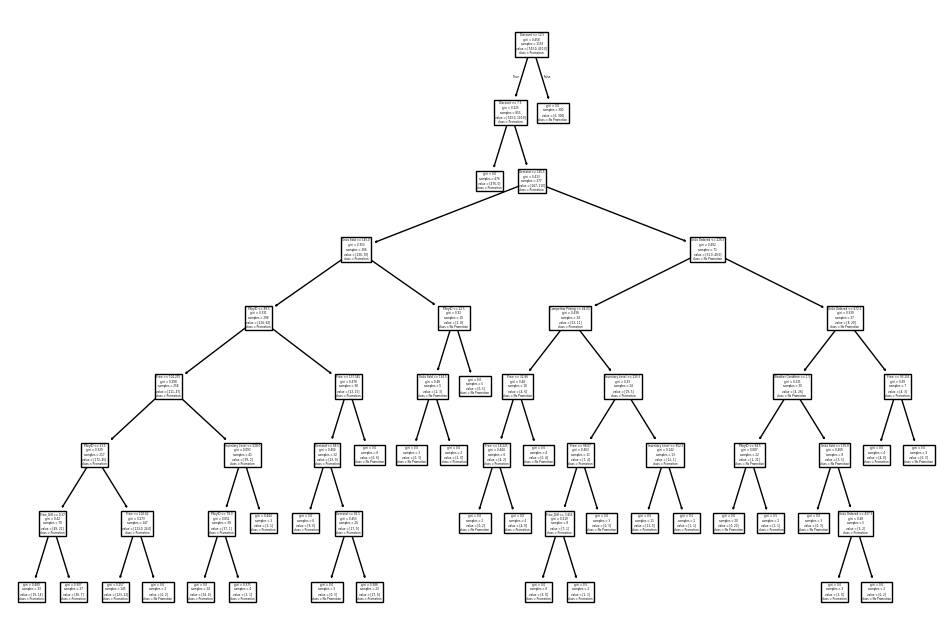

In [149]:
# We plot the decision tree to check if our model is interpretable. 
feature_names = X_train.columns
plt.figure(figsize=(12,8))
tree.plot_tree(dt_gini.fit(X_train, y_train),feature_names=feature_names, class_names=['Promotion', 'No Promotion'])

In [150]:
# We can also get our rules in textual format
feature_names = X_train.columns
text_representation = tree.export_text(dt_gini, feature_names=feature_names)
print(text_representation)

|--- Discount <= 12.50
|   |--- Discount <= 7.50
|   |   |--- class: 0
|   |--- Discount >  7.50
|   |   |--- Demand <= 145.50
|   |   |   |--- Units Sold <= 145.00
|   |   |   |   |--- PKeyID <= 89.50
|   |   |   |   |   |--- Price <= 104.24
|   |   |   |   |   |   |--- PKeyID <= 23.50
|   |   |   |   |   |   |   |--- Price_Diff <= 0.37
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- Price_Diff >  0.37
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- PKeyID >  23.50
|   |   |   |   |   |   |   |--- Price <= 102.62
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- Price >  102.62
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- Price >  104.24
|   |   |   |   |   |   |--- Inventory Level <= 528.00
|   |   |   |   |   |   |   |--- PKeyID <= 78.00
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- PKeyID >  78.00
|   |   |   |   |   |   |   |   |--- clas

Text(0.5, 1.0, 'Confusion Matrix')

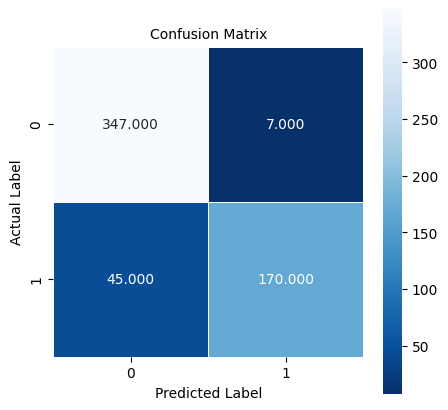

In [151]:
# We use the confusion matrix to visualize the performance of our classifier.
# It helps us understand how well the model distinguishes between the classes,
# showing the number of correct and incorrect predictions for each class.
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_gini)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix, annot=True, fmt=".3f", linewidths=.5, square=True, cmap="Blues_r")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix', size = 10)

In [152]:
# We analyze the classification report to get further insights into the performance of our model
print(classification_report(y_test, y_pred_gini))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       354
           1       0.96      0.79      0.87       215

    accuracy                           0.91       569
   macro avg       0.92      0.89      0.90       569
weighted avg       0.91      0.91      0.91       569



## Entropy SV

In [153]:
df_esv = pd.read_csv("../../Data/Transformed/Julius/inventory_management_transformed.csv", index_col=0)
df_esv

,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,Weather Condition,Promotion,Competitor Pricing,Demand,PKeyID,Weekday,Price_Diff
Category,,,,,,,,,,,,,
1,1,195,102,252,72.72,5,1,0,85.73,115,0,2,-13.01
0,1,117,117,249,80.16,15,1,1,92.02,229,1,2,-11.86
0,1,247,114,612,62.94,10,1,1,60.08,157,2,2,2.86
1,1,139,45,102,87.63,10,1,0,85.19,52,3,2,2.44
3,1,152,65,271,54.41,0,1,0,51.63,59,4,2,2.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,1,129,129,128,62.83,10,0,0,74.57,143,17,5,-11.74
2,1,104,54,50,98.97,10,0,1,88.85,54,18,5,10.12
2,1,494,56,0,111.25,10,0,0,102.91,70,19,5,8.34


In [154]:
# We define that y equals the attribute we want to predict and X equals all the other attributes to predict y 
y_esv = df_esv["Promotion"]
X_esv = df_esv.loc[:, df.columns != 'Promotion']

# Check if y equals our predict variable
y_esv

Category
1    0
0    1
0    1
1    0
3    0
    ..
3    0
2    1
2    0
3    0
4    1
Name: Promotion, Length: 1722, dtype: int64

In [155]:
# Check for X
X_esv

,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,Weather Condition,Competitor Pricing,Demand,PKeyID,Weekday,Price_Diff
Category,,,,,,,,,,,,
1,1,195,102,252,72.72,5,1,85.73,115,0,2,-13.01
0,1,117,117,249,80.16,15,1,92.02,229,1,2,-11.86
0,1,247,114,612,62.94,10,1,60.08,157,2,2,2.86
1,1,139,45,102,87.63,10,1,85.19,52,3,2,2.44
3,1,152,65,271,54.41,0,1,51.63,59,4,2,2.78
...,...,...,...,...,...,...,...,...,...,...,...,...
3,1,129,129,128,62.83,10,0,74.57,143,17,5,-11.74
2,1,104,54,50,98.97,10,0,88.85,54,18,5,10.12
2,1,494,56,0,111.25,10,0,102.91,70,19,5,8.34


In [156]:
# Check out the imbalance
y_esv.value_counts()

Promotion
0    1097
1     625
Name: count, dtype: int64

In [157]:
# We split our Data into test and train Data so we can later train on the train data and measure the performance on the test data
X_train_esv, X_test_esv, y_train_esv, y_test_esv = train_test_split(X_esv, y_esv, test_size=0.33, random_state=42)
X_train_esv.shape, X_test_esv.shape
print("Before:", Counter(y_train_esv))

Before: Counter({0: 743, 1: 410})


In [158]:
# We run different trees with different paramaters and store the ones with the best accuracy. We use for loops to iterate through all combinations
# We store the best params to use them for further analysis 
max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
min_samples_split = [2, 3, 4, 5]
min_samples_leaf = [2, 3, 4, 5]

best_score = 0
best_params_entropy = {}

for depth in max_depth:
    for split in min_samples_split:
        for leaf in min_samples_leaf:
            dt_entropy = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=depth, min_samples_split=split, min_samples_leaf=leaf, random_state=42)
            dt_entropy.fit(X_train_esv, y_train_esv)
            y_pred_entropy = dt_entropy.predict(X_test_esv)
            acc = accuracy_score(y_test_esv, y_pred_entropy)

            #print(f"max_depth = {depth}, min_samples_split = {split}, min_samples_leaf = {leaf} -> Accuracy = {acc:.4f}")

            if acc > best_score:
                best_score = acc
                best_params_entropy = {
                    'max_depth': depth,
                    'min_samples_split': split,
                    'min_samples_leaf': leaf
                }

print(f"\nBest parameters: {best_params_entropy} with accuracy: {best_score}")


Best parameters: {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 2} with accuracy: 0.9068541300527241


In [159]:
# We build the tree and calculate the accuracy based on the best paramters we have derived for the entropy tree
dt_entropy = DecisionTreeClassifier(criterion='entropy', splitter='best', **best_params_entropy, random_state=42)
dt_entropy.fit(X_train_esv, y_train_esv)
y_pred_entropy = dt_entropy.predict(X_test_esv)
accuracy_test_entropy_nosmote = accuracy_score (y_test_esv, y_pred_entropy)
print(accuracy_test_entropy_nosmote)

0.9068541300527241


In [160]:
# We want to check wether our model is robust or if it is dependant on the data. The only way to check this for split validation, is to 
# evaluate the accuracy based on the train data and compare the results with the accuracy of the test data. If they
# deviate less than 5%, the model is independant of the underlying data and thus is robust
y_pred_train_entropy = dt_entropy.predict(X_train_esv)
accuracy_train_entropy_nosmote = accuracy_score(y_train_esv, y_pred_train_entropy)
print(accuracy_train_entropy_nosmote)
if abs(accuracy_test_entropy_nosmote-accuracy_train_entropy_nosmote) < (0.05*accuracy_test_entropy_nosmote): 
    print("Passed the Robustness Check!")
else: 
    print("Didn't pass the Robustness Check!")

0.9124024284475282
Passed the Robustness Check!


<a id="interpret"></a>

[Text(0.6, 0.875, 'Discount <= 12.5\nentropy = 0.939\nsamples = 1153\nvalue = [743.0, 410.0]\nclass = No Promotion'),
 Text(0.4, 0.625, 'Discount <= 7.5\nentropy = 0.555\nsamples = 853\nvalue = [743.0, 110.0]\nclass = No Promotion'),
 Text(0.5, 0.75, 'True  '),
 Text(0.2, 0.375, 'entropy = 0.0\nsamples = 476\nvalue = [476, 0]\nclass = No Promotion'),
 Text(0.6, 0.375, 'Demand <= 145.5\nentropy = 0.871\nsamples = 377\nvalue = [267, 110]\nclass = No Promotion'),
 Text(0.4, 0.125, 'entropy = 0.776\nsamples = 306\nvalue = [236, 70]\nclass = No Promotion'),
 Text(0.8, 0.125, 'entropy = 0.988\nsamples = 71\nvalue = [31.0, 40.0]\nclass = Promotion'),
 Text(0.8, 0.625, 'entropy = 0.0\nsamples = 300\nvalue = [0, 300]\nclass = Promotion'),
 Text(0.7, 0.75, '  False')]

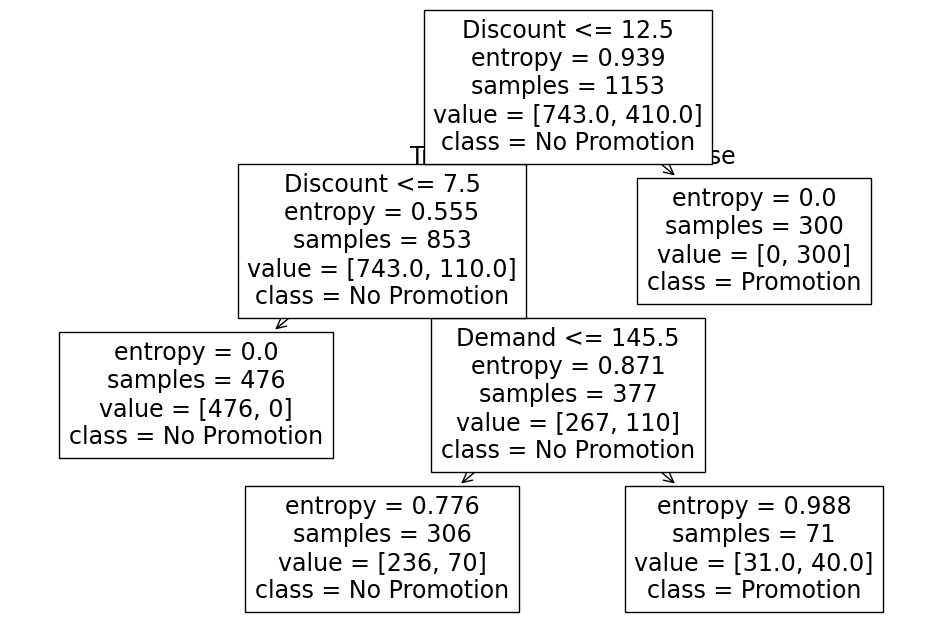

In [161]:
# We plot the decision tree to check if our model is interpretable. 
feature_names = X_train_esv.columns
plt.figure(figsize=(12,8))
tree.plot_tree(dt_entropy.fit(X_train_esv, y_train_esv),feature_names=feature_names, class_names=['No Promotion', 'Promotion'])

Text(0.5, 1.0, 'Confusion Matrix')

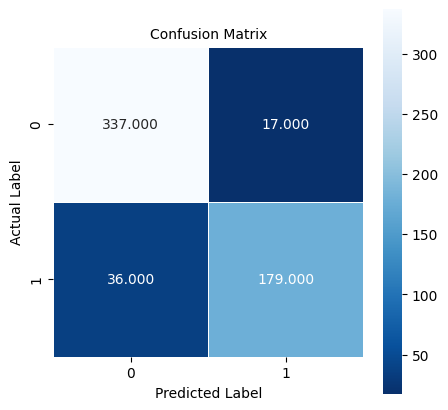

In [162]:
# We use the confusion matrix to visualize the performance of our classifier.
# It helps us understand how well the model distinguishes between the classes,
# showing the number of correct and incorrect predictions for each class.
confusion_matrix = metrics.confusion_matrix(y_test_esv, y_pred_entropy)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix, annot=True, fmt=".3f", linewidths=.5, square=True, cmap="Blues_r")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix', size = 10)

In [163]:
# We analyze the classification report to get further insights into the performance of our model
print(classification_report(y_test_esv, y_pred_entropy))

              precision    recall  f1-score   support

           0       0.90      0.95      0.93       354
           1       0.91      0.83      0.87       215

    accuracy                           0.91       569
   macro avg       0.91      0.89      0.90       569
weighted avg       0.91      0.91      0.91       569



## Gini CV

In [164]:
df_gcv = pd.read_csv("../../Data/Transformed/Julius/inventory_management_transformed.csv", index_col=0)
df_gcv

,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,Weather Condition,Promotion,Competitor Pricing,Demand,PKeyID,Weekday,Price_Diff
Category,,,,,,,,,,,,,
1,1,195,102,252,72.72,5,1,0,85.73,115,0,2,-13.01
0,1,117,117,249,80.16,15,1,1,92.02,229,1,2,-11.86
0,1,247,114,612,62.94,10,1,1,60.08,157,2,2,2.86
1,1,139,45,102,87.63,10,1,0,85.19,52,3,2,2.44
3,1,152,65,271,54.41,0,1,0,51.63,59,4,2,2.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,1,129,129,128,62.83,10,0,0,74.57,143,17,5,-11.74
2,1,104,54,50,98.97,10,0,1,88.85,54,18,5,10.12
2,1,494,56,0,111.25,10,0,0,102.91,70,19,5,8.34


In [165]:
# We define that y equals the attribute we want to predict and X equals all the other attributes to predict y 
y_gcv = df["Promotion"]
X_gcv = df.loc[:, df.columns != 'Promotion']

In [166]:
# Check the imbalance
y_gcv.value_counts()

Promotion
0    1097
1     625
Name: count, dtype: int64

In [167]:
# We split our Data into test and train Data so we can later train on the train data and measure the performance on the test data
X_train_gcv, X_test_gcv, y_train_gcv, y_test_gcv = train_test_split(X_gcv, y_gcv, test_size=0.33, random_state=42)
X_train_gcv.shape, X_test_gcv.shape
print("Before:", Counter(y_train_gcv))

Before: Counter({0: 743, 1: 410})


In [168]:
# We use stratified cross validation to get a robust model with the same class balances in each fold
kf_gcv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [169]:
# We use the best parameters that we have derived before
best_params_gini = {'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 2}

In [170]:
# We start with building trees based on the cross validation
# We see that we have a robust model because our accuracy score is independant of the data combinations
# Our average accuracy is the mean of the different scores
score_gcv = cross_val_score(tree.DecisionTreeClassifier(criterion='gini', splitter='best', **best_params_gini, random_state=42), X_gcv, y_gcv, cv=kf_gcv, scoring="accuracy")
print(score_gcv)
average_accuracy_gcv = score_gcv.mean()
average_accuracy_gcv

[0.94219653 0.9132948  0.93023256 0.86627907 0.85465116 0.89534884
 0.89534884 0.87790698 0.91860465 0.88953488]


0.8983398306223955

In [171]:
# We now want to find the best parameters based on the cross validation
# We start with a tree with no specified parameters
dt_noparam_gcv = DecisionTreeClassifier(criterion='gini', splitter='best', random_state=42)
dt_noparam_gcv.fit(X_train_gcv, y_train_gcv)
y_pred_gcv = dt_noparam_gcv.predict(X_test_gcv)
accuracy_score(y_test_gcv, y_pred_gcv)

0.8963093145869947

[Text(0.7562144886363636, 0.9705882352941176, 'Discount <= 12.5\ngini = 0.458\nsamples = 1153\nvalue = [743.0, 410.0]\nclass = No Promotion'),
 Text(0.7410629734848485, 0.9117647058823529, 'Discount <= 7.5\ngini = 0.225\nsamples = 853\nvalue = [743.0, 110.0]\nclass = No Promotion'),
 Text(0.7486387310606061, 0.9411764705882353, 'True  '),
 Text(0.7259114583333334, 0.8529411764705882, 'gini = 0.0\nsamples = 476\nvalue = [476, 0]\nclass = No Promotion'),
 Text(0.7562144886363636, 0.8529411764705882, 'Demand <= 145.5\ngini = 0.413\nsamples = 377\nvalue = [267, 110]\nclass = No Promotion'),
 Text(0.6336410984848485, 0.7941176470588235, 'Units Sold <= 145.0\ngini = 0.353\nsamples = 306\nvalue = [236, 70]\nclass = No Promotion'),
 Text(0.5551609848484849, 0.7352941176470589, 'PKeyID <= 89.5\ngini = 0.331\nsamples = 296\nvalue = [234, 62]\nclass = No Promotion'),
 Text(0.44365530303030304, 0.6764705882352942, 'Price <= 104.235\ngini = 0.298\nsamples = 258\nvalue = [211, 47]\nclass = No Promot

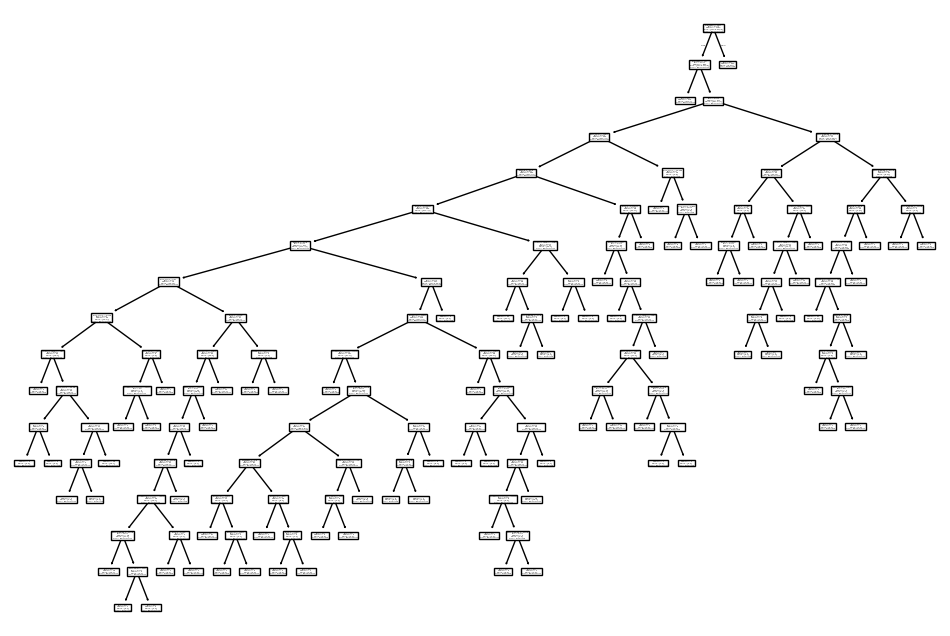

In [172]:
# We plot the tree with no specified paramters to look at the unpruned tree
feature_names = X_train_gcv.columns
plt.figure(figsize=(12, 8))
tree.plot_tree(dt_noparam_gcv.fit(X_train_gcv, y_train_gcv), feature_names=feature_names, class_names=['No Promotion', 'Promotion'])

In [173]:
# We set a range of Parameters that GridSearchCV will try out for us in every possible combination
params = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8], 'min_samples_leaf': [2, 3, 4, 5]}
clf = tree.DecisionTreeClassifier(criterion='gini', splitter='best', random_state=42)

# Note that we tried out different scoring paramters like accuracy, f1, recall. Because we want to keep the interpretability with a max. depth of 4, it would lead to the same results
gcv = GridSearchCV(estimator=clf, param_grid=params, return_train_score=True, cv=10)
gcv.fit(X_train_gcv, y_train_gcv)
print(gcv.best_params_)

# We also used RandomizedSearchCV to compare the best paramaters with another method. We noticed that the results are always different, so we decided to stick 
# with the GridSearchCV, as best parameters are always constant. We know that there is an option to always get the same result (random_state), but as our paramter
# space is rather small, GridSearchCV works perfectly fine
rcv = RandomizedSearchCV(estimator=clf, param_distributions=params, return_train_score=True, cv=10)
rcv.fit(X_train_gcv, y_train_gcv)
print(rcv.best_params_)

{'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 2}
{'min_samples_split': 6, 'min_samples_leaf': 5, 'max_depth': 6}


In [174]:
# We want to look at the different scores for the different splits and parameters to check if the model is overfitting or not
results = gcv.cv_results_
results_df = pd.DataFrame(results)
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.001878,0.000515,0.000690,0.000178,1,2,2,"{'max_depth': 1, 'min_samples_leaf': 2, 'min_s...",0.896552,0.905172,...,0.903568,0.907514,0.898844,0.906551,0.904624,0.903661,0.905588,0.905588,0.904597,0.002239
1,0.001366,0.000193,0.000495,0.000068,1,2,3,"{'max_depth': 1, 'min_samples_leaf': 2, 'min_s...",0.896552,0.905172,...,0.903568,0.907514,0.898844,0.906551,0.904624,0.903661,0.905588,0.905588,0.904597,0.002239
2,0.001347,0.000096,0.000578,0.000169,1,2,4,"{'max_depth': 1, 'min_samples_leaf': 2, 'min_s...",0.896552,0.905172,...,0.903568,0.907514,0.898844,0.906551,0.904624,0.903661,0.905588,0.905588,0.904597,0.002239
3,0.001339,0.000105,0.000550,0.000124,1,2,5,"{'max_depth': 1, 'min_samples_leaf': 2, 'min_s...",0.896552,0.905172,...,0.903568,0.907514,0.898844,0.906551,0.904624,0.903661,0.905588,0.905588,0.904597,0.002239
4,0.001293,0.000081,0.000495,0.000076,1,2,6,"{'max_depth': 1, 'min_samples_leaf': 2, 'min_s...",0.896552,0.905172,...,0.903568,0.907514,0.898844,0.906551,0.904624,0.903661,0.905588,0.905588,0.904597,0.002239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,0.002767,0.000145,0.000535,0.000078,12,5,4,"{'max_depth': 12, 'min_samples_leaf': 5, 'min_...",0.913793,0.887931,...,0.952748,0.954721,0.951830,0.955684,0.947013,0.950867,0.958574,0.962428,0.954515,0.004037
332,0.002806,0.000151,0.000550,0.000069,12,5,5,"{'max_depth': 12, 'min_samples_leaf': 5, 'min_...",0.913793,0.887931,...,0.952748,0.954721,0.951830,0.955684,0.947013,0.950867,0.958574,0.962428,0.954515,0.004037
333,0.002784,0.000136,0.000548,0.000081,12,5,6,"{'max_depth': 12, 'min_samples_leaf': 5, 'min_...",0.913793,0.887931,...,0.952748,0.954721,0.951830,0.955684,0.947013,0.950867,0.958574,0.962428,0.954515,0.004037
334,0.002786,0.000096,0.000556,0.000073,12,5,7,"{'max_depth': 12, 'min_samples_leaf': 5, 'min_...",0.913793,0.887931,...,0.952748,0.954721,0.951830,0.955684,0.947013,0.950867,0.958574,0.962428,0.954515,0.004037


In [175]:
# This is the best possible score based on the test data, we can check for overfitting by comparing with the accuracy score for the test data
accuracy_cv_gini_nosmote = gcv.best_score_
print(accuracy_cv_gini_nosmote)

0.9201724137931034


In [176]:
# These are the best possible estimators on which the model should be trained on 
print(gcv.best_estimator_)
model = gcv.best_estimator_
model.fit(X_train_gcv, y_train_gcv)
y_pred_pruned_gcv = model.predict(X_test_gcv)
print(accuracy_score(y_test_gcv, y_pred_pruned_gcv))

DecisionTreeClassifier(max_depth=6, min_samples_leaf=5, random_state=42)
0.9015817223198594


[Text(0.5217391304347826, 0.9285714285714286, 'Discount <= 12.5\ngini = 0.458\nsamples = 1153\nvalue = [743.0, 410.0]\nclass = No Promotion'),
 Text(0.4782608695652174, 0.7857142857142857, 'Discount <= 7.5\ngini = 0.225\nsamples = 853\nvalue = [743.0, 110.0]\nclass = No Promotion'),
 Text(0.5, 0.8571428571428572, 'True  '),
 Text(0.43478260869565216, 0.6428571428571429, 'gini = 0.0\nsamples = 476\nvalue = [476, 0]\nclass = No Promotion'),
 Text(0.5217391304347826, 0.6428571428571429, 'Demand <= 145.5\ngini = 0.413\nsamples = 377\nvalue = [267, 110]\nclass = No Promotion'),
 Text(0.2826086956521739, 0.5, 'Units Sold <= 145.0\ngini = 0.353\nsamples = 306\nvalue = [236, 70]\nclass = No Promotion'),
 Text(0.17391304347826086, 0.35714285714285715, 'PKeyID <= 89.5\ngini = 0.331\nsamples = 296\nvalue = [234, 62]\nclass = No Promotion'),
 Text(0.08695652173913043, 0.21428571428571427, 'Price <= 104.235\ngini = 0.298\nsamples = 258\nvalue = [211, 47]\nclass = No Promotion'),
 Text(0.04347826086

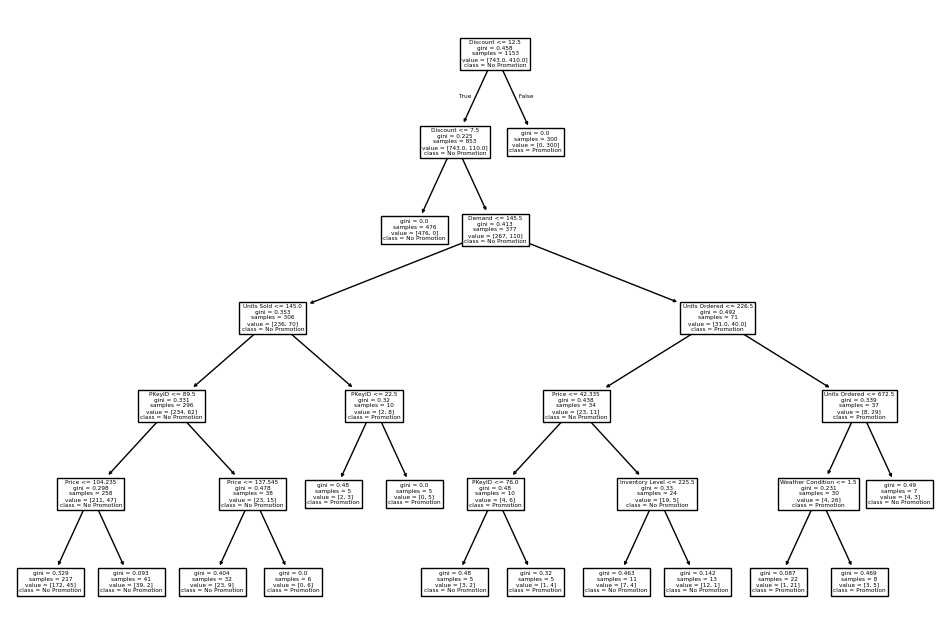

In [177]:
# We plot the pruned tree
feature_names = X_train_gcv.columns
plt.figure(figsize=(12, 8))
tree.plot_tree(model, feature_names=feature_names, class_names=['No Promotion', 'Promotion'])

In [178]:
# We can also get our rules in textual format
feature_names = X_train_gcv.columns
text_representation = tree.export_text(model, feature_names=feature_names)
print(text_representation)

|--- Discount <= 12.50
|   |--- Discount <= 7.50
|   |   |--- class: 0
|   |--- Discount >  7.50
|   |   |--- Demand <= 145.50
|   |   |   |--- Units Sold <= 145.00
|   |   |   |   |--- PKeyID <= 89.50
|   |   |   |   |   |--- Price <= 104.24
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- Price >  104.24
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- PKeyID >  89.50
|   |   |   |   |   |--- Price <= 137.54
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- Price >  137.54
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- Units Sold >  145.00
|   |   |   |   |--- PKeyID <= 22.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- PKeyID >  22.50
|   |   |   |   |   |--- class: 1
|   |   |--- Demand >  145.50
|   |   |   |--- Units Ordered <= 226.50
|   |   |   |   |--- Price <= 42.34
|   |   |   |   |   |--- PKeyID <= 76.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- PKeyID >  76.00
|   |   |   |   |   |   |--- class: 1


Text(0.5, 1.0, 'Confusion Matrix')

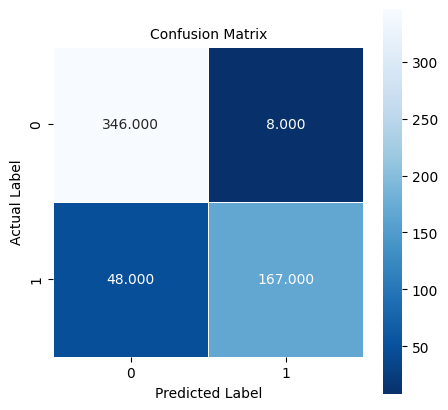

In [179]:
# We use the confusion matrix to visualize the performance of our classifier.
# It helps us understand how well the model distinguishes between the classes,
# showing the number of correct and incorrect predictions for each class.
confusion_matrix_gcv = metrics.confusion_matrix(y_test_gcv, y_pred_pruned_gcv)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix_gcv, annot=True, fmt=".3f", linewidths=.5, square=True, cmap="Blues_r")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix', size = 10)

In [180]:
# We analyze the classification report to get further insights in the performance of our model
print(classification_report(y_test_gcv, y_pred_pruned_gcv))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       354
           1       0.95      0.78      0.86       215

    accuracy                           0.90       569
   macro avg       0.92      0.88      0.89       569
weighted avg       0.91      0.90      0.90       569



## Entropy CV

In [181]:
df_ecv = pd.read_csv("../../Data/Transformed/Julius/inventory_management_transformed.csv", index_col=0)
df_ecv

,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,Weather Condition,Promotion,Competitor Pricing,Demand,PKeyID,Weekday,Price_Diff
Category,,,,,,,,,,,,,
1,1,195,102,252,72.72,5,1,0,85.73,115,0,2,-13.01
0,1,117,117,249,80.16,15,1,1,92.02,229,1,2,-11.86
0,1,247,114,612,62.94,10,1,1,60.08,157,2,2,2.86
1,1,139,45,102,87.63,10,1,0,85.19,52,3,2,2.44
3,1,152,65,271,54.41,0,1,0,51.63,59,4,2,2.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,1,129,129,128,62.83,10,0,0,74.57,143,17,5,-11.74
2,1,104,54,50,98.97,10,0,1,88.85,54,18,5,10.12
2,1,494,56,0,111.25,10,0,0,102.91,70,19,5,8.34


In [182]:
# We define that y equals the attribute we want to predict and X equals all the other attributes to predict y 
y_ecv = df_ecv["Promotion"]
X_ecv = df_ecv.loc[:, df.columns != 'Promotion']

In [183]:
# See the imbalance
y_ecv.value_counts()

Promotion
0    1097
1     625
Name: count, dtype: int64

In [184]:
# We split our Data into test and train Data so we can later train on the train data and measure the performance on the test data
X_train_ecv, X_test_ecv, y_train_ecv, y_test_ecv = train_test_split(X_ecv, y_ecv, test_size=0.33, random_state=42)
X_train_ecv.shape, X_test_ecv.shape
print("Before:", Counter(y_train_ecv))

Before: Counter({0: 743, 1: 410})


In [185]:
# We use stratified cross validation to get a robust model with the same class balances in each fold
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [186]:
# We use the best parameters that we have derived before
best_params_entropy = {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 2}
# Best parameters: {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 2} with accuracy: 0.9068541300527241

In [187]:
# We start with building trees based on the cross validation
# We see that we have a robust model because our accuracy score is independant of the data combinations
# Our average accuracy is the mean of the different scores
score_ecv = cross_val_score(tree.DecisionTreeClassifier(criterion='entropy', splitter='best', **best_params_entropy, random_state=42), X_ecv, y_ecv, cv=kf, scoring="accuracy")
print(score_ecv)
average_accuracy = score_ecv.mean()
average_accuracy

[0.92485549 0.90751445 0.88372093 0.89534884 0.87209302 0.88953488
 0.88372093 0.91860465 0.90116279 0.88372093]


0.8960276918940717

In [188]:
# We now want to find the best parameters based on the cross validation
# We start with a tree with no specified parameters
dt_noparam = DecisionTreeClassifier(criterion='entropy', splitter='best', random_state=42)
dt_noparam.fit(X_train_ecv, y_train_ecv)
y_pred_ecv = dt_noparam.predict(X_test_ecv)
accuracy_score(y_test_ecv, y_pred_ecv)

0.8804920913884007

[Text(0.696156103286385, 0.975, 'Discount <= 12.5\nentropy = 0.939\nsamples = 1153\nvalue = [743.0, 410.0]\nclass = No Promotion'),
 Text(0.6773767605633803, 0.925, 'Discount <= 7.5\nentropy = 0.555\nsamples = 853\nvalue = [743.0, 110.0]\nclass = No Promotion'),
 Text(0.6867664319248826, 0.95, 'True  '),
 Text(0.6585974178403756, 0.875, 'entropy = 0.0\nsamples = 476\nvalue = [476, 0]\nclass = No Promotion'),
 Text(0.696156103286385, 0.875, 'Demand <= 145.5\nentropy = 0.871\nsamples = 377\nvalue = [267, 110]\nclass = No Promotion'),
 Text(0.5425469483568075, 0.825, 'Units Sold <= 145.0\nentropy = 0.776\nsamples = 306\nvalue = [236, 70]\nclass = No Promotion'),
 Text(0.44190140845070425, 0.775, 'PKeyID <= 85.5\nentropy = 0.74\nsamples = 296\nvalue = [234, 62]\nclass = No Promotion'),
 Text(0.29694835680751175, 0.725, 'Price <= 123.69\nentropy = 0.676\nsamples = 247\nvalue = [203, 44]\nclass = No Promotion'),
 Text(0.27816901408450706, 0.675, 'Price_Diff <= -1.16\nentropy = 0.706\nsamples

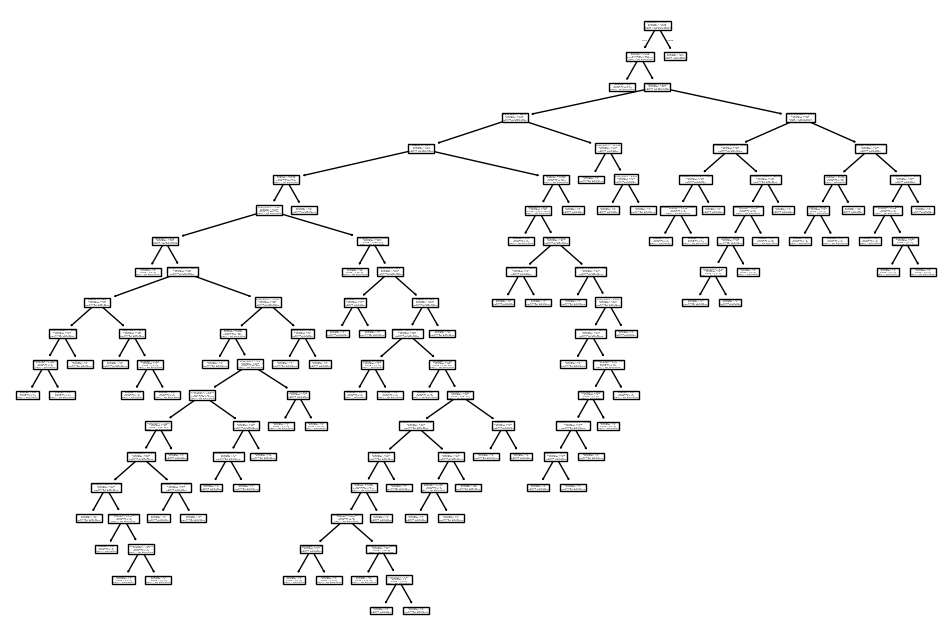

In [189]:
# We plot the tree with no specified paramters to look at the unpruned tree
feature_names = X_train_ecv.columns
plt.figure(figsize=(12, 8))
tree.plot_tree(dt_noparam.fit(X_train_ecv, y_train_ecv), feature_names=feature_names, class_names=['No Promotion', 'Promotion'])

In [190]:
# We set a range of Parameters that GridSearchCV will try out for us in every possible combination
params = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8], 'min_samples_leaf': [2, 3, 4, 5]}
clf = tree.DecisionTreeClassifier(criterion='entropy', splitter='best', random_state=42)

ecv = GridSearchCV(estimator=clf, param_grid=params, return_train_score=True, cv = 10)
ecv.fit(X_train_ecv, y_train_ecv)
ecv.best_params_

{'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [191]:
# We want to look at the different scores for the different splits and parameters to check if the model is overfitting or not
results_ecv = ecv.cv_results_
results_df = pd.DataFrame(results_ecv)
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.001544,0.000208,0.000633,0.000331,1,2,2,"{'max_depth': 1, 'min_samples_leaf': 2, 'min_s...",0.896552,0.905172,...,0.903568,0.907514,0.898844,0.906551,0.904624,0.903661,0.905588,0.905588,0.904597,0.002239
1,0.001561,0.000251,0.000543,0.000083,1,2,3,"{'max_depth': 1, 'min_samples_leaf': 2, 'min_s...",0.896552,0.905172,...,0.903568,0.907514,0.898844,0.906551,0.904624,0.903661,0.905588,0.905588,0.904597,0.002239
2,0.001437,0.000136,0.000487,0.000035,1,2,4,"{'max_depth': 1, 'min_samples_leaf': 2, 'min_s...",0.896552,0.905172,...,0.903568,0.907514,0.898844,0.906551,0.904624,0.903661,0.905588,0.905588,0.904597,0.002239
3,0.001381,0.000102,0.000516,0.000083,1,2,5,"{'max_depth': 1, 'min_samples_leaf': 2, 'min_s...",0.896552,0.905172,...,0.903568,0.907514,0.898844,0.906551,0.904624,0.903661,0.905588,0.905588,0.904597,0.002239
4,0.001379,0.000064,0.000539,0.000113,1,2,6,"{'max_depth': 1, 'min_samples_leaf': 2, 'min_s...",0.896552,0.905172,...,0.903568,0.907514,0.898844,0.906551,0.904624,0.903661,0.905588,0.905588,0.904597,0.002239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,0.003207,0.000127,0.000552,0.000058,12,5,4,"{'max_depth': 12, 'min_samples_leaf': 5, 'min_...",0.896552,0.887931,...,0.961427,0.951830,0.947977,0.961464,0.943160,0.959538,0.962428,0.964355,0.956443,0.006628
332,0.003211,0.000130,0.000554,0.000065,12,5,5,"{'max_depth': 12, 'min_samples_leaf': 5, 'min_...",0.896552,0.887931,...,0.961427,0.951830,0.947977,0.961464,0.943160,0.959538,0.962428,0.964355,0.956443,0.006628
333,0.003219,0.000155,0.000556,0.000066,12,5,6,"{'max_depth': 12, 'min_samples_leaf': 5, 'min_...",0.896552,0.887931,...,0.961427,0.951830,0.947977,0.961464,0.943160,0.959538,0.962428,0.964355,0.956443,0.006628
334,0.003190,0.000144,0.000556,0.000066,12,5,7,"{'max_depth': 12, 'min_samples_leaf': 5, 'min_...",0.896552,0.887931,...,0.961427,0.951830,0.947977,0.961464,0.943160,0.959538,0.962428,0.964355,0.956443,0.006628


In [192]:
# This is the best possible score based on the test data, we can check for overfitting by comparing with the accuracy score for the test data
accuracy_cv_entropy_nosmote = gcv.best_score_
print(accuracy_cv_entropy_nosmote)

0.9201724137931034


In [193]:
# These are the best possible estimators on which the model should be trained on 
print(gcv.best_estimator_)
model = gcv.best_estimator_
model.fit(X_train, y_train)
y_pred_pruned_ecv = model.predict(X_test_ecv)
print(accuracy_score(y_test_ecv, y_pred_pruned_ecv))

DecisionTreeClassifier(max_depth=6, min_samples_leaf=5, random_state=42)
0.9015817223198594


[Text(0.5217391304347826, 0.9285714285714286, 'Discount <= 12.5\ngini = 0.458\nsamples = 1153\nvalue = [743.0, 410.0]\nclass = No Promotion'),
 Text(0.4782608695652174, 0.7857142857142857, 'Discount <= 7.5\ngini = 0.225\nsamples = 853\nvalue = [743.0, 110.0]\nclass = No Promotion'),
 Text(0.5, 0.8571428571428572, 'True  '),
 Text(0.43478260869565216, 0.6428571428571429, 'gini = 0.0\nsamples = 476\nvalue = [476, 0]\nclass = No Promotion'),
 Text(0.5217391304347826, 0.6428571428571429, 'Demand <= 145.5\ngini = 0.413\nsamples = 377\nvalue = [267, 110]\nclass = No Promotion'),
 Text(0.2826086956521739, 0.5, 'Units Sold <= 145.0\ngini = 0.353\nsamples = 306\nvalue = [236, 70]\nclass = No Promotion'),
 Text(0.17391304347826086, 0.35714285714285715, 'PKeyID <= 89.5\ngini = 0.331\nsamples = 296\nvalue = [234, 62]\nclass = No Promotion'),
 Text(0.08695652173913043, 0.21428571428571427, 'Price <= 104.235\ngini = 0.298\nsamples = 258\nvalue = [211, 47]\nclass = No Promotion'),
 Text(0.04347826086

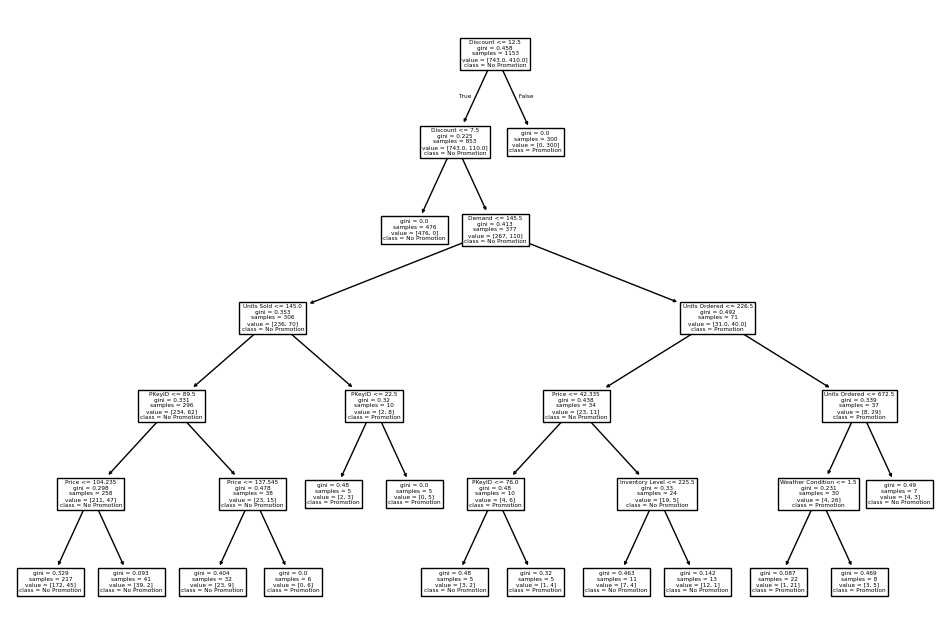

In [194]:
# We plot the pruned tree
feature_names = X_train_ecv.columns
plt.figure(figsize=(12, 8)) # try out with different fig sizes
tree.plot_tree(model, feature_names=feature_names, class_names=['No Promotion', 'Promotion'])

In [195]:
# We can also get our rules in textual format
feature_names = X_train_ecv.columns
text_representation = tree.export_text(model, feature_names=feature_names)
print(text_representation)

|--- Discount <= 12.50
|   |--- Discount <= 7.50
|   |   |--- class: 0
|   |--- Discount >  7.50
|   |   |--- Demand <= 145.50
|   |   |   |--- Units Sold <= 145.00
|   |   |   |   |--- PKeyID <= 89.50
|   |   |   |   |   |--- Price <= 104.24
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- Price >  104.24
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- PKeyID >  89.50
|   |   |   |   |   |--- Price <= 137.54
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- Price >  137.54
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- Units Sold >  145.00
|   |   |   |   |--- PKeyID <= 22.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- PKeyID >  22.50
|   |   |   |   |   |--- class: 1
|   |   |--- Demand >  145.50
|   |   |   |--- Units Ordered <= 226.50
|   |   |   |   |--- Price <= 42.34
|   |   |   |   |   |--- PKeyID <= 76.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- PKeyID >  76.00
|   |   |   |   |   |   |--- class: 1


Text(0.5, 1.0, 'Confusion Matrix')

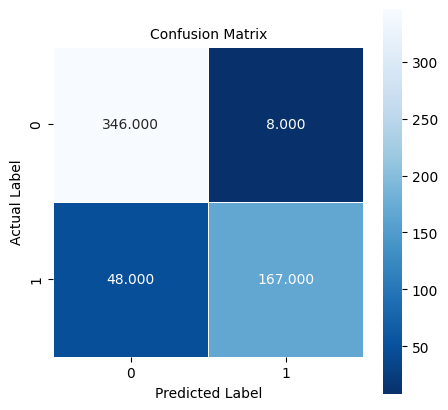

In [196]:
# We use the confusion matrix to visualize the performance of our classifier.
# It helps us understand how well the model distinguishes between the classes,
# showing the number of correct and incorrect predictions for each class.
confusion_matrix = metrics.confusion_matrix(y_test_ecv, y_pred_pruned_ecv)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix, annot=True, fmt=".3f", linewidths=.5, square=True, cmap="Blues_r")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix', size = 10)

In [197]:
# We analyze the classification report to get further insights in the performance of our model
print(classification_report(y_test_ecv, y_pred_pruned_ecv))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       354
           1       0.95      0.78      0.86       215

    accuracy                           0.90       569
   macro avg       0.92      0.88      0.89       569
weighted avg       0.91      0.90      0.90       569



# Conclusion

We looked at all trees generated. We didnt use SMOTE in this case since the data is quite good and there is no need to impute data, since it also manipulates the data a little.

Criterias:
1. Interpretability
  - Entropy SV
2. Robustness
  - All trees are robust
3. Accuracy
  - Entropy SV
  - Gini SV

Over all is Entropy SV the best tree.